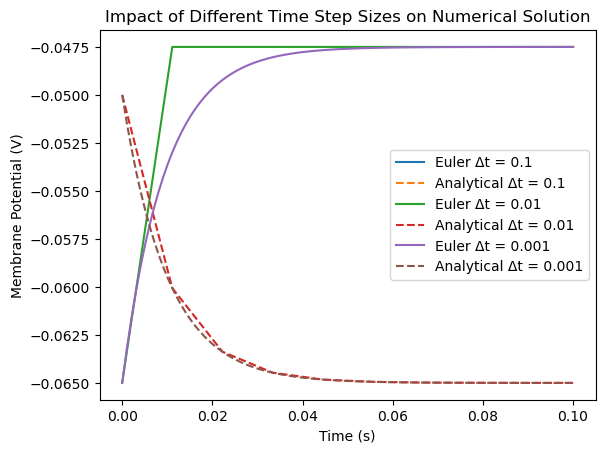

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

#Here are the general parameters
v_thres: float = -0.05
v_rest:float = -0.065
duration:float = 0.1
V_init:float = -0.065
tau: float = 0.010

#analytical solution
def analytical_solution(t:float = 0.1, v_rest:float = 0.065, v_thresh:float = 0.05, tau:float = 0.010) -> np.ndarray:
    return v_rest + (v_thresh - v_rest) * np.exp(-t / tau)


# LIAF equation function
def leaky(t: float, v: np.ndarray, tau: float = 0.010, r: float = 50e6, vrest: float= -0.065, inp: float = 0.35e-9) -> np.ndarray:
    return np.array([-(v[0] - vrest) / tau + r * inp / tau])

#euler integration 
def euler_integration(v_init: float, duration: float, dt: float, tau: float, r: float, v_rest: float, inp: float) -> np.ndarray:
    num_steps = int(duration / dt)
    t_vals = np.linspace(0, duration, num_steps)
    v_vals = np.zeros(num_steps)
    v_vals[0] = v_init
    
    for i in range(1, num_steps):
        v_vals[i] = v_vals[i-1] + dt * leaky(t_vals[i-1], np.array([v_vals[i-1]]), tau, r, v_rest, inp)[0]
    
    return t_vals, v_vals


# Compare numerical and analytical solutions
time_steps = [10e-2, 10e-3, 10e-4]

plt.figure()

for dt in time_steps:
    t_euler, v_euler = euler_integration(V_init, duration, dt, tau, 50e6, v_rest, 0.35e-9)
    v_analytic = analytical_solution(t_euler, v_rest, v_thres, tau)
    
    plt.plot(t_euler, v_euler, label=f'Euler Δt = {dt}')
    plt.plot(t_euler, v_analytic, '--', label=f'Analytical Δt = {dt}')
    
plt.xlabel('Time (s)')
plt.ylabel('Membrane Potential (V)')
plt.title('Impact of Different Time Step Sizes on Numerical Solution')
plt.legend()
plt.show()



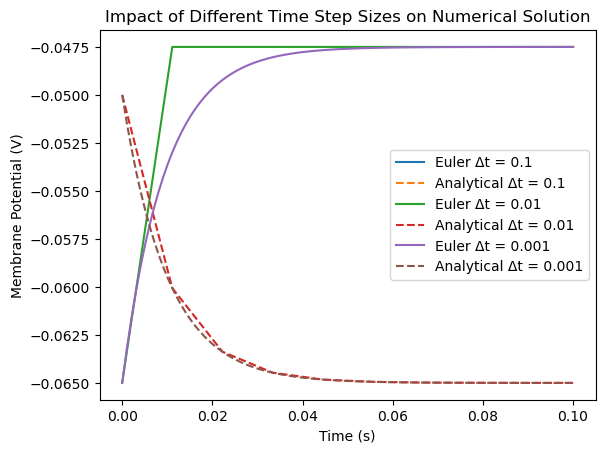

In [3]:
#Comparing efect of different step sizes

tau = 0.010
time_steps = [10e-2, 10e-3, 10e-4]

plt.figure()

# Compare
for dt in time_steps:
    t_euler, v_euler = euler_integration(V_init, duration, dt, tau, 50e6, v_rest, 0.35e-9)
    v_analytic = analytical_solution(t_euler, v_rest, v_thres, tau)
    
    plt.plot(t_euler, v_euler, label=f'Euler Δt = {dt}')
    plt.plot(t_euler, v_analytic, '--', label=f'Analytical Δt = {dt}')
    
plt.xlabel('Time (s)')
plt.ylabel('Membrane Potential (V)')
plt.title('Impact of Different Time Step Sizes on Numerical Solution')
plt.legend()
plt.show()

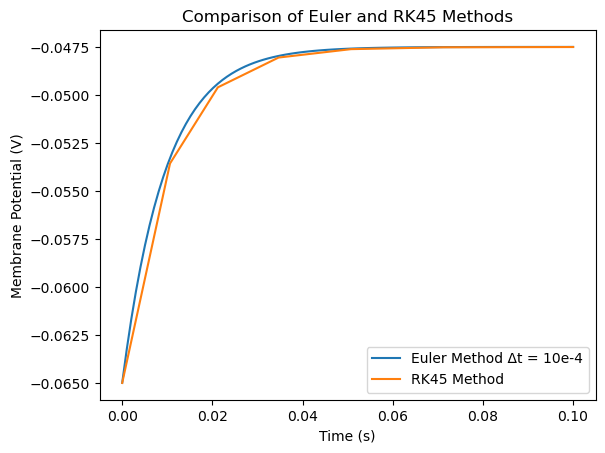

In [4]:
#Now using the solver
plt.figure()

# Euler
t_euler, v_euler = euler_integration(V_init, duration, dt, tau, 50e6, v_rest, 0.35e-9)

# Solver
sol = solve_ivp(leaky, [0, duration], [V_init])

# Graficar las soluciones
plt.plot(t_euler, v_euler, label='Euler Method Δt = 10e-4')
plt.plot(sol.t, sol.y[0], label='RK45 Method')
plt.xlabel('Time (s)')
plt.ylabel('Membrane Potential (V)')
plt.title('Comparison of Euler and RK45 Methods')
plt.legend()
plt.show()

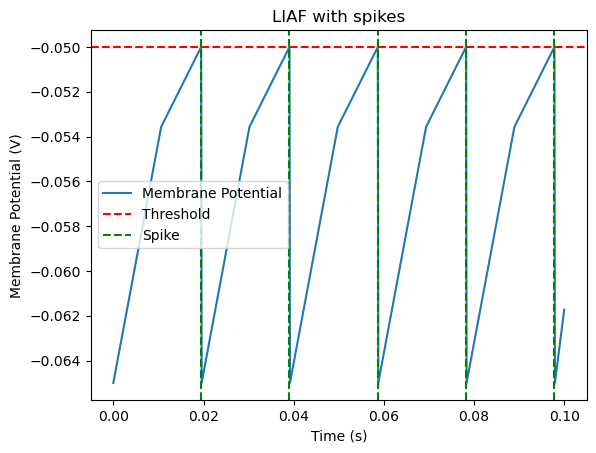

In [5]:
 # spike event
def spike(t: float, v: np.ndarray) -> float:
    return v[0] - v_thres 

spike.terminal = True  # stop if spike
spike.direction = 1 

# to store the results
t_total = []
v_total = []
t_start = 0
V_current = V_init
spike_times = []

# Continue integration after it stopped and reset 
while t_start < duration:
    sol = solve_ivp(leaky, [t_start, duration], [V_current], events=spike)
    
    t_total.extend(sol.t)
    v_total.extend(sol.y[0])
    
    if sol.status == 1:
        spike_times.append(sol.t_events[0][0])
        V_current = v_rest
        t_start = sol.t_events[0][0] + 1e-4
    else:
        break  

# plot
plt.plot(t_total, v_total, label='Membrane Potential')
plt.axhline(y=v_thres, color='r', linestyle='--', label='Threshold')
plt.xlabel('Time (s)')
plt.ylabel('Membrane Potential (V)')
plt.title('LIAF with spikes')

for spike_time in spike_times:
    plt.axvline(x=spike_time, color='g', linestyle='--', label='Spike' if spike_time == spike_times[0] else "")

plt.legend()
plt.show()

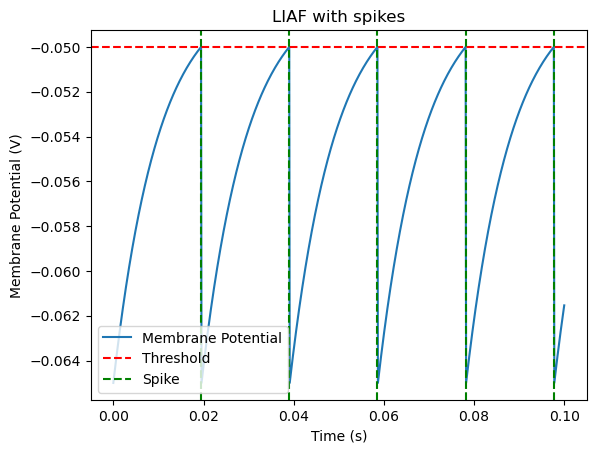

In [6]:
# Here I include the max step so that the plot doesn't look edgy

# to store the results
t_total = []
v_total = []
t_start = 0
V_current = V_init
spike_times = []

# Continue integration after it stopped and reset 
while t_start < duration:
    sol = solve_ivp(leaky, [t_start, duration], [V_current], max_step = 1e-4, events=spike)
    
    t_total.extend(sol.t)
    v_total.extend(sol.y[0])
    
    if sol.status == 1:
        spike_times.append(sol.t_events[0][0])
        V_current = v_rest
        t_start = sol.t_events[0][0] + 1e-4
    else:
        break  

# plot
plt.plot(t_total, v_total, label='Membrane Potential')
plt.axhline(y=v_thres, color='r', linestyle='--', label='Threshold')
plt.xlabel('Time (s)')
plt.ylabel('Membrane Potential (V)')
plt.title('LIAF with spikes')

for spike_time in spike_times:
    plt.axvline(x=spike_time, color='g', linestyle='--', label='Spike' if spike_time == spike_times[0] else "")

plt.legend()
plt.show()

Hodgkin-Huxley

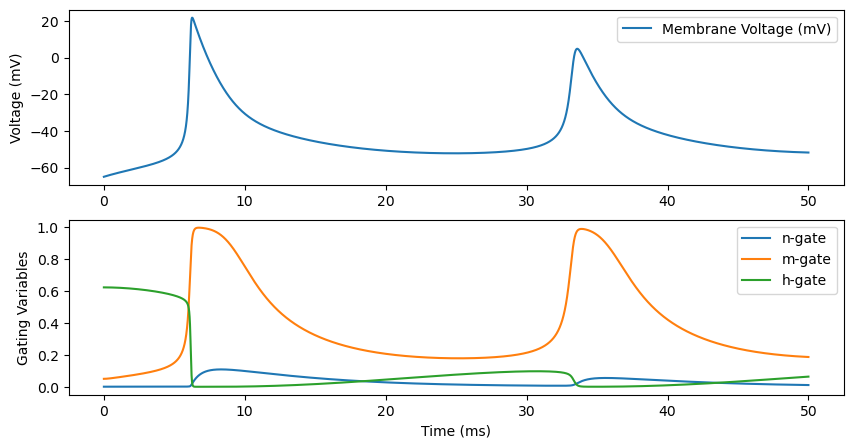

In [7]:

# Coverted to use the formulas in the appendix
C = 1  # µF
g_Na = 40  # mS
g_K = 35  # mS
g_L = 0.3  # mS
V_Na = 55  # mV
V_K = -77  # mV
V_L = -65  # mV

#these are the functions on the appendix

def alpha_n(V):
    return 0.02 * (V - 25) / (1 - np.exp(-(V - 25) / 9))

def beta_n(V):
    return -0.002 * (V - 25) / (1 - np.exp((V - 25) / 9))

def alpha_m(V):
    return 0.182 * (V + 35) / (1 - np.exp(-(V + 35) / 9))

def beta_m(V):
    return -0.124 * (V + 35) / (1 - np.exp((V + 35) / 9))

def alpha_h(V):
    return 0.25 * np.exp(-(V + 90) / 12)

def beta_h(V):
    return 0.25 * np.exp((V + 62) / 6 - (V + 90) / 12)

#define function to integrate equations
def HH_equations(t, y, I_ext):
    V, n, m, h = y
    
    dVdt = (-g_K * n**4 * (V - V_K) - g_Na * m**3 * h * (V - V_Na) - g_L * (V - V_L) + I_ext) / C
    dndt = alpha_n(V) * (1 - n) - beta_n(V) * n
    dmdt = alpha_m(V) * (1 - m) - beta_m(V) * m
    dhdt = alpha_h(V) * (1 - h) - beta_h(V) * h
    
    return [dVdt, dndt, dmdt, dhdt]

def euler(dt, T, I_ext):
    time = np.arange(0, T, dt)
    V = np.zeros(len(time))
    n = np.zeros(len(time))
    m = np.zeros(len(time))
    h = np.zeros(len(time))
    
    V[0] = -65  # Initialize in -65mV 
    n[0] = alpha_n(V[0]) / (alpha_n(V[0]) + beta_n(V[0]))
    m[0] = alpha_m(V[0]) / (alpha_m(V[0]) + beta_m(V[0]))
    h[0] = alpha_h(V[0]) / (alpha_h(V[0]) + beta_h(V[0]))
    
    for i in range(1, len(time)):
        dVdt, dndt, dmdt, dhdt = HH_equations(time[i-1], [V[i-1], n[i-1], m[i-1], h[i-1]], I_ext)
        V[i] = V[i-1] + dt * dVdt
        n[i] = n[i-1] + dt * dndt
        m[i] = m[i-1] + dt * dmdt
        h[i] = h[i-1] + dt * dhdt
    
    return time, V, n, m, h

# Parameters
T = 50  # total time in miliseconds
dt = 10e-5  # Step size in miliseconds
I_ext = 2 # External input current, which I varied until observed spikes

time, V, n, m, h = euler(dt, T, I_ext)

# Plot
plt.figure(figsize=(10, 5))

plt.subplot(2, 1, 1)
plt.plot(time, V, label='Membrane Voltage (mV)')
plt.ylabel('Voltage (mV)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time, n, label='n-gate')
plt.plot(time, m, label='m-gate')
plt.plot(time, h, label='h-gate')
plt.ylabel('Gating Variables')
plt.xlabel('Time (ms)')
plt.legend()
plt.show()


/tmp/ipykernel_70989/2661818718.py:13: RuntimeWarning: overflow encountered in exp
  return 0.02 * (V - 25) / (1 - np.exp(-(V - 25) / 9))
/tmp/ipykernel_70989/2661818718.py:19: RuntimeWarning: overflow encountered in exp
  return 0.182 * (V + 35) / (1 - np.exp(-(V + 35) / 9))
/tmp/ipykernel_70989/2661818718.py:25: RuntimeWarning: overflow encountered in exp
  return 0.25 * np.exp(-(V + 90) / 12)
/usr/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


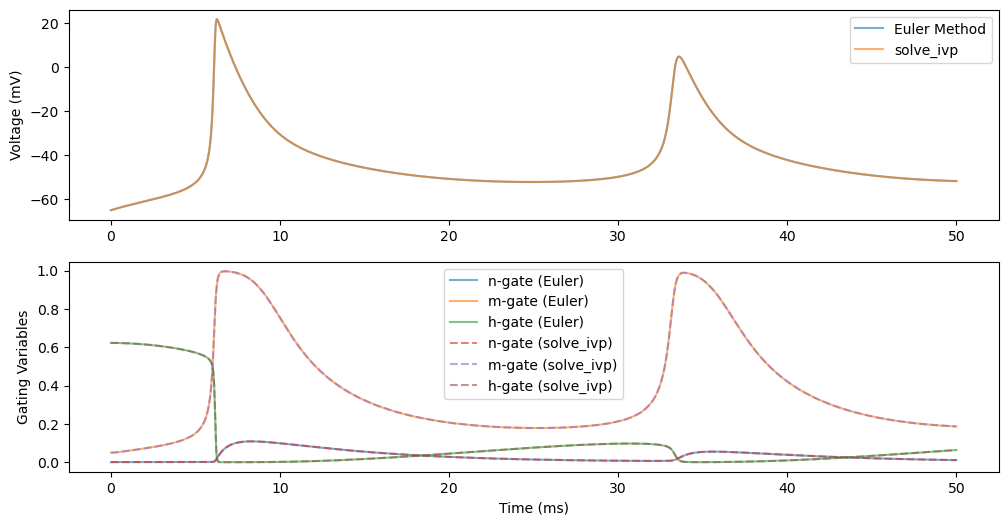

In [8]:

# solve using solve_ivp
def HH_equations_ivp(t, y):
    return HH_equations(t, y, I_ext) #I use the equations I already had before

sol_ivp = solve_ivp(HH_equations_ivp, [0, T], [-65, n[0], m[0], h[0]], method='RK45', t_eval=time)

# plot comparison
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time, V, label='Euler Method', alpha=0.6)
plt.plot(sol_ivp.t, sol_ivp.y[0], label='solve_ivp', alpha=0.6)
plt.ylabel('Voltage (mV)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time, n, label='n-gate (Euler)', alpha=0.6)
plt.plot(time, m, label='m-gate (Euler)', alpha=0.6)
plt.plot(time, h, label='h-gate (Euler)', alpha=0.6)
plt.plot(sol_ivp.t, sol_ivp.y[1], label='n-gate (solve_ivp)', linestyle='dashed', alpha=0.6)
plt.plot(sol_ivp.t, sol_ivp.y[2], label='m-gate (solve_ivp)', linestyle='dashed', alpha=0.6)
plt.plot(sol_ivp.t, sol_ivp.y[3], label='h-gate (solve_ivp)', linestyle='dashed', alpha=0.6)
plt.ylabel('Gating Variables')
plt.xlabel('Time (ms)')
plt.legend()
plt.show()
